<a href="https://colab.research.google.com/github/smurli/ai-challenge-mars/blob/master/IMG_COMPLETION/image_completion_test_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
GPATH="/content/gdrive/My Drive/aiml/OmdenaMars/"
os.environ["GPATH"] = GPATH


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BASE_PATH="/content/data/"
os.environ["BASE_PATH"] = BASE_PATH

TRAIN_NATURAL_PATH=BASE_PATH+"train/"+"natural/"
os.environ["TRAIN_NATURAL_PATH"] = TRAIN_NATURAL_PATH

TEST_NATURAL_PATH=BASE_PATH+"test/"+"natural/"
os.environ["TEST_NATURAL_PATH"] = TEST_NATURAL_PATH

TEST_TECHNO_PATH=BASE_PATH+"test/"+"techno/"
os.environ["TEST_TECHNO_PATH"] = TEST_TECHNO_PATH

TMP_PATH=BASE_PATH+"tmp/"
os.environ["TMP_PATH"] = TMP_PATH

WEIGHTS_PATH=GPATH+"weights/image-completion-v2/"
os.environ["WEIGHTS_PATH"] = WEIGHTS_PATH

RESULTS_PATH=BASE_PATH+"results/"
os.environ["RESULTS_PATH"] = RESULTS_PATH


In [0]:
import pathlib
from shutil import copyfile
import os
import pandas as pd

pathlib.Path(TRAIN_NATURAL_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TEST_NATURAL_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TEST_TECHNO_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TMP_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(WEIGHTS_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

#if not os.path.isfile(BASE_PATH+"natural.tgz"):
#    print("Copying natural.tgz to local folder")
#    copyfile(GPATH+"natural.tgz", BASE_PATH+"natural.tgz")
#if not os.path.isfile(BASE_PATH+"techno.tgz"):
#    print("Copying techno.tgz to local folder")
#    copyfile(GPATH+"techno.tgz", BASE_PATH+"techno.tgz")

In [0]:
!cp "$GPATH""techno.tgz" $BASE_PATH
!cp "$GPATH""techno-stride16.tgz" $BASE_PATH
!cp "$GPATH""natural.tgz" $BASE_PATH

In [0]:
!rm -rf "/content/data/techno"
!cd $BASE_PATH; tar xzf techno.tgz
!mv "/content/data/content/gdrive/My Drive/aiml/OmdenaMars/data/techno" $BASE_PATH
!cd $BASE_PATH; tar xzf techno-stride16.tgz

!cd $BASE_PATH; tar xzf natural.tgz
!mv "/content/data/content/gdrive/My Drive/aiml/OmdenaMars/data/natural" $BASE_PATH


In [0]:
import shutil
import os
from PIL import Image

for dir in os.listdir(BASE_PATH+"techno/"):
    print("Moving Files from:", dir+":")
    for file in os.listdir(BASE_PATH+"techno/"+dir):
        #print(file)
        shutil.copy(BASE_PATH+"techno/"+dir+"/"+file, TRAIN_NATURAL_PATH+file)

count = 204800
print("Moving Natural File")
for file in os.listdir(BASE_PATH+"natural/"):
    f1 = file.split("_")
    xVal = int(f1[2])
    yVal = int(f1[4].split(".")[0])
    if (xVal >= 8000) and (yVal>=5000):
        if(xVal <= 15000) and (yVal <= 30000):
            shutil.move(BASE_PATH+"natural/"+file, TRAIN_NATURAL_PATH+file)
            count -= 1
            if (count <= 0):
                break


Moving Files from: Parachute:
Moving Files from: Heat-Sheild:
Moving Files from: Descent-Stage-Crash-Site:
Moving Files from: 2-new-spots-spot2:
Moving Files from: 2-new-spots-spot1:
Moving Files from: Curiosoity-Rover:
Moving Natural File


# Define Model

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, UpSampling2D
from keras.backend import clip
from keras.initializers import RandomNormal
from keras.optimizers import Adam

from keras.constraints import Constraint
from keras import backend as K

import tensorflow as tf

import numpy as np
import csv

from keras.utils. generic_utils import Progbar


Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
IMAGE_SIZE = 128
MASK_SIZE = 32
LAMBDA = 0.9

SAVE_EVERY_EPOCH = 5
TEST_EVERY_EPOCH = 5

In [0]:
#from: https://stackoverflow.com/questions/42264567/keras-ml-library-how-to-do-weight-clipping-after-gradient-updates-tensorflow-b
class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, c=1):
        self.c = c

    def __call__(self, p):
        return K.clip(p, -self.c, self.c)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'c': self.c}


def defineModel():
    
    kernelInitializer = RandomNormal(mean=0.0, stddev=1, seed=None)

    #where Conv(k; d; s; c) denotes a convolutional layer with kernel size k x k, dilation rate d, stride s and c output channels.
    model = Sequential()

    #Conv(5; 1; 1; 32)
    model.add(Conv2D(input_shape = (128,128,1), 
                     filters=32, kernel_size=5, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 2; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=2, padding="same", activation="elu"))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 2; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=2, strides=1, padding="same", activation="elu"))

    #Conv(3; 4; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=4, strides=1, padding="same", activation="elu"))

    #Conv(3; 8; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=8, strides=1, padding="same", activation="elu"))

    #Conv(3; 16; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=16, strides=1, padding="same", activation="elu"))
    #model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=8, strides=1))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Bilinear Upscaling(2x)
    model.add(UpSampling2D(size=2, interpolation="bilinear"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=32, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 32)
    model.add(Conv2D(filters=32, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 16)
    model.add(Conv2D(filters=16, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 1) + Clip(-1; 1)
    model.add(Conv2D(filters=1, kernel_size=3, dilation_rate=1, strides=1, padding="same", W_constraint = WeightClip(1), activation="elu"))

    return model

W0725 13:54:56.106265 139914087843712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 13:54:56.149610 139914087843712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 13:54:56.161565 139914087843712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 13:54:56.372509 139914087843712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2020: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.

/usr/local/lib/python3.6/di

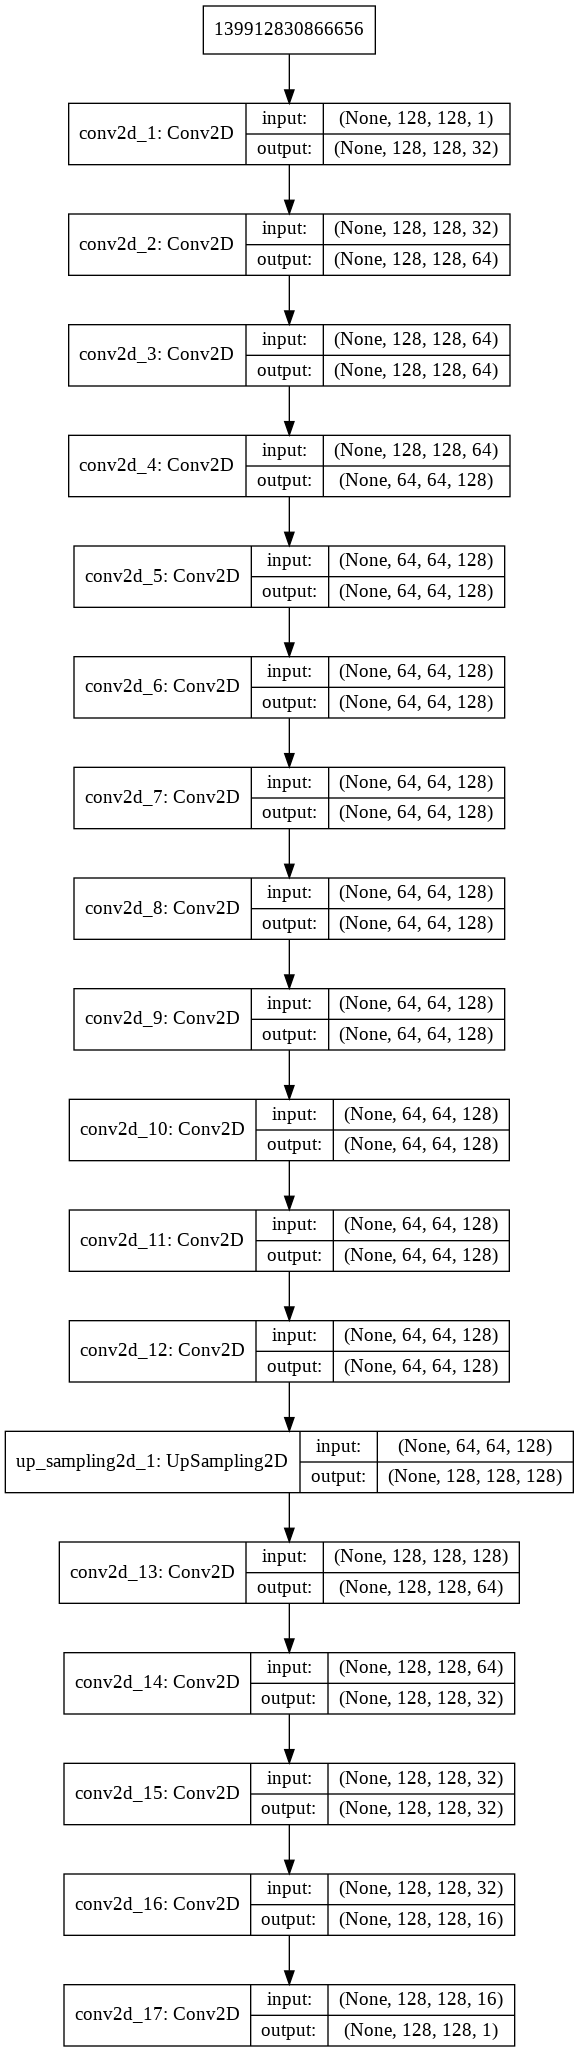

In [0]:
from keras.utils import plot_model, vis_utils
from IPython.display import Image
from IPython.display import display

import IPython

model = defineModel()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image(retina=True,filename='model.png'))

In [0]:
import keras.backend as K
import tensorflow as tf 


def getMaskArray(aSize, mSize):
    m = np.ones((aSize, aSize))
    haSize = int(aSize/2)
    hmSize = int(mSize/2)
    m[haSize-hmSize:haSize+hmSize, haSize-hmSize:haSize+hmSize] = 0
    return m


def getLoss(aSize, mSize):
    
    m1 = getMaskArray(aSize,mSize)
    m2 = np.repeat(m1[np.newaxis, :, :, np.newaxis], BATCH_SIZE, axis=0)
    mask = K.variable(m2)
    invMask = K.variable(1-mask)
    imgSize = K.variable(IMAGE_SIZE)
    batchSize = K.variable(BATCH_SIZE)
    lam = K.variable(LAMBDA)
    def anoLoss(y_true, y_pred):
        d1 = tf.math.multiply(mask, (y_true - tf.math.multiply(invMask,y_pred)))
        d2 = tf.math.multiply(invMask, (y_true - tf.math.multiply(invMask,y_pred)))
        v1 = (lam*tf.norm(d1,ord=1))/(imgSize*imgSize)
        v2 = (lam*tf.norm(d2,ord=1))/(imgSize*imgSize)
        r = (v1+v2)/batchSize
        #d = tf.Print(r, [r], "Inside loss function")
        return r
        
    return anoLoss


In [0]:
model = defineModel()
model.compile(optimizer="adam",
              loss=getLoss(IMAGE_SIZE,MASK_SIZE), # Call the loss function with the selected layer
              metrics=['accuracy'])
model.load_weights(WEIGHTS_PATH+"model.epoch-300.h5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=1, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu", kernel_constraint=<__main__....)`
W0725 13:55:05.355982 139914087843712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0725 13:55:05.390857 139914087843712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 13:55:08.661178 139914087843712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-pa

In [0]:
import cv2
from numpy import newaxis
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

def anomalyScore(y_true, y_pred):
    mask = getMaskArray(IMAGE_SIZE, 24)
    invMask = 1-mask
    y_masked_true = np.multiply(y_true, invMask)
    y_masked_pred = np.multiply(y_pred, invMask)
    diff = (((y_masked_true-y_masked_pred)**2).sum())/(24*24)
    return diff

def testModel(model, dir):
    folder=TRAIN_NATURAL_PATH
    files = []
    scores = [] 
    mask = getMaskArray(IMAGE_SIZE, MASK_SIZE)
    invMask = 1-mask
    mulMask = invMask[:, :, np.newaxis]

    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename),0)
        img = cv2.resize(img,(128,128))
        imgScaled = (img.astype(np.float32) - 127.5) / 127.5
        imgScaled = np.array([imgScaled])
        imgScaled = imgScaled[:,:,:,newaxis]
        imgMasked = np.multiply(imgScaled,mulMask)
        imgPredict = model.predict(imgMasked)
        #score = anomalyScore(imgMasked, imgPredict)
        score = anomalyScore(imgScaled, imgPredict)
        files.append(filename)
        scores.append(score)
        #plt.imshow(img, cmap='gray')
        #plt.imshow(im3[0,:,:,0], cmap='gray')
        #plt.imshow(imgPredict[0,:,:,0], cmap='gray')
        #plt.show()
    return pd.DataFrame({'files':files, 'scores':scores})



In [0]:
#%debug
naturalDf = testModel(model,"natural")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ffde95160>]],
      dtype=object)

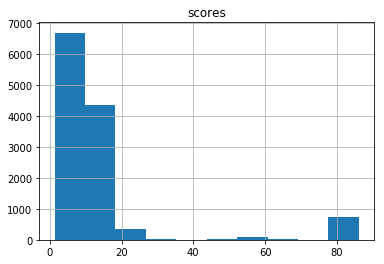

In [0]:
naturalDf.hist()

In [0]:
naturalDf.sort_values("scores").tail(10)

,files,scores
7094,img_x_6976_y_20688.jpg,82.509080
6194,img_x_7152_y_20704.jpg,82.632513
3972,img_x_7264_y_20720.jpg,82.743854
11669,img_x_7104_y_20704.jpg,82.792820
10881,img_x_7120_y_20704.jpg,83.560937
1612,img_x_7216_y_20720.jpg,83.776995
10329,img_x_6992_y_20688.jpg,84.321147
7736,img_x_7136_y_20704.jpg,84.918039
5912,img_x_7248_y_20720.jpg,85.493204
7813,img_x_7232_y_20720.jpg,86.123165


In [0]:
dfFileIndex = naturalDf.set_index("files")
#print(dfFileIndex.head())
for dir in os.listdir(BASE_PATH+"techno/"):
    print("Scores for:", dir+":")
    for file in os.listdir(BASE_PATH+"techno/"+dir):
        print(file,":",dfFileIndex.loc[file].scores)


Scores for: Parachute:
img_x_7520_y_22320.jpg : 80.2912946388526
img_x_7424_y_22256.jpg : 80.2912946388526
img_x_7584_y_22288.jpg : 80.2912946388526
img_x_7664_y_22336.jpg : 80.2912946388526
img_x_7440_y_22400.jpg : 80.2912946388526
img_x_7424_y_22416.jpg : 80.2912946388526
img_x_7424_y_22448.jpg : 80.2912946388526
img_x_7632_y_22432.jpg : 80.2912946388526
img_x_7472_y_22384.jpg : 80.2912946388526
img_x_7408_y_22288.jpg : 80.2912946388526
img_x_7648_y_22464.jpg : 80.2912946388526
img_x_7584_y_22400.jpg : 80.2912946388526
img_x_7552_y_22336.jpg : 80.2912946388526
img_x_7600_y_22224.jpg : 80.2912946388526
img_x_7600_y_22352.jpg : 80.2912946388526
img_x_7456_y_22304.jpg : 80.2912946388526
img_x_7488_y_22384.jpg : 80.2912946388526
img_x_7616_y_22336.jpg : 80.2912946388526
img_x_7680_y_22224.jpg : 80.2912946388526
img_x_7504_y_22224.jpg : 80.2912946388526
img_x_7456_y_22336.jpg : 80.2912946388526
img_x_7536_y_22416.jpg : 80.2912946388526
img_x_7680_y_22176.jpg : 80.2912946388526
img_x_7504_

In [0]:
found = []
notFound = []
cutOffScore = (naturalDf["scores"].mean() + (naturalDf["scores"].std()*3))
foundCount = 0
print("cutOffScore:",cutOffScore)
#for img in naturalDf[naturalDf.scores>cutOffScore].files:
for dir in os.listdir(BASE_PATH+"techno/"):
    if dir not in notFound:
        notFound.append(dir)

for img in naturalDf[naturalDf.scores>cutOffScore].files:
    for dir in os.listdir(BASE_PATH+"techno/"):
        if img in os.listdir(BASE_PATH+"techno/"+dir):
            foundCount +=1
            if dir not in found:
                found.append(dir)
                if dir in notFound:
                    notFound.remove(dir)

print("Anomaly detected:",found, "Count:", foundCount)
print("Anomaly not-detected:",notFound)

cutOffScore: 67.85673262605813
Anomaly detected: ['Parachute', 'Heat-Sheild', 'Descent-Stage-Crash-Site', 'Curiosoity-Rover'] Count: 741
Anomaly not-detected: ['2-new-spots-spot2', '2-new-spots-spot1']


In [0]:
naturalDf[naturalDf.scores>cutOffScore].count()

files     741
scores    741
dtype: int64